## General Model



## Import useful packages

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
#from keras.utils import plot_model
import random
from botocore.exceptions import ClientError
import yaml
#import ktrain



In [2]:
with open('model.yml') as config_file:
    config_data = yaml.load(config_file)
    image_dir = config_data['image_dir']
    latstart= config_data['latstart']
    latend=config_data['latend']
    longstart = config_data['longstart']
    longend=config_data['longend']
    dtstart= config_data['dtstart']
    dtend=config_data['dtend']

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [4]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


In [5]:
def haversine_loss(y_true, y_pred, denorm=(36.0, 4.0, -78.0, 4.0), R=3443.92):
    """
    Returns the mean squared haversine distance
    between arrays consisting of lattitudes and
    longitudes.
    
    Args:
        y_true:  Either an np.array or a tf.constant
                 of dimensions m x 2 where m in the
                 number of observations.  Each row is
                 an ordered pair of [lat, long].
                 
        y_pred:  Has the same form as y_true.
        
        dnorm:   A tuple of four values needed to
                 convert normalized lat and long back
                 to actual values.
        
        R:       Float giving the radius of the earth.
                 The default value is in nautical
                 miles.  Values in other units:
                 
                 kilometers    -> 6378.14
                 statute miles -> 3963.19
                 smoots        -> 3.748e+6
        
    Returns:
        tf.tensor of shape () and dtype float64 giving
        the mean square distance error using the
        haversine function.
    
    Examples:
    
        Input:
        y1     = np.array([[0, 0]])
        y_hat1 = np.array([[0, 180]])
        
        Expected result:
        (pi * R) ** 2 = 117059281.6 nm^2
        
        Input:
        y2     = np.array([[0, 0]])
        y_hat2 = np.array([[90, 0]])
        
        Expected result:
        (pi * R / 2) ** 2 = 29264820.4 nm^2
        
        Input:
        Portmsouth, VA to Rota, Spain
        y3     = tf.constant([[36.8354, -76.2983]])
        y_hat3 = tf.constant([[36.6237, -6.3601]])
        
        Expected result:
        37065212.0 km^2
        
    Notes:
        Closely follows the JS implmentation at
        https://www.movable-type.co.uk/scripts/latlong.html.
    """
    # Break inputs into lattitudes and longitudes for
    # convienience

    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = denorm
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(d)

### Key image read-in functions: load_image and build_input

In [6]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [7]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [8]:
def build_labels(file_list,files_to_load):
    y = []
    t=[]
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            time = file_split[2].split('.')[0]
            y.append((lat, long))
            t.append(time)
    return np.array(y),np.array(t)

#### Test load_image on one image manually

(224, 224)
[[ 36.00147625 -74.82905304]] ['2020-05-26T01:10:59']


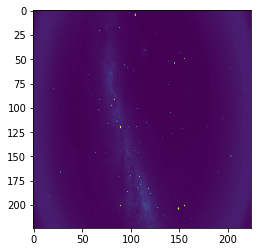

In [9]:
bucket_name='w251-final-project'
file_name='36.0014762509164+-74.82905304191733+2020-05-26T01:10:59.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)
file_list=[file_name]
test_label, test_time=build_labels(file_list,1)
print (test_label,test_time)

## Prepare the data

### Load the images

In [18]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=False

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')
    t=np.load('t.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=500
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('About to call build_input on',files_to_load,' files')
    dim=(224,224)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('Building labels')
    y,t = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)
    np.save('t.npy',t)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)
print ('shape of time list:',t.shape)

loading from files
shape of image array: (500, 224, 224)
shape of label list: (500, 2)
shape of time list: (500,)



### Standardize the values

In [19]:
def scale_down(numbers,top,bottom):
    number_range=top-bottom
    revised=[x-bottom for x in numbers]
    revised=[x/number_range for x in revised]
    return revised

def scale_up(number,top,bottom):
    number_range=top-bottom
    revised=number*number_range
    revised=revised+bottom
    return revised

def normalize_times(times, t_min, t_max):
    """
    Converts times to a float bounded by [0,1]
    
    Args:
        times: numpy.array with dtype datetime64
				t_min: time to fix as 0
				t_max: time to fix as 1
        
    Returns:
        numpy.array of decimal times bounded on [0,1]
    """
    time_range = (t_max - t_min).astype('float64')
    seconds_from_t0 = (times - t_min).astype('float64')
    
    return seconds_from_t0 / time_range




In [20]:
#just scaling down without normalizing
y[:,0]=scale_down(y[:,0],latend,latstart)
y[:,1]=scale_down(y[:,1],longend,longstart)

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

0.47703348371365917 0.2996816554458038
0.49227650530311345 0.2930379213818846


In [21]:
#normalize times
dtstart=np.datetime64(dtstart)
dtend=np.datetime64(dtend)
#print(dtstart,dtend)
t=[np.datetime64(x) for x in t]
t=normalize_times(t,dtstart,dtend)
print (t.mean(),t.std())

0.4752352777777778 0.2926160640904934


### Split into test and training sets

In [22]:
X_train, X_val, y_train, y_val,t_train,t_val = train_test_split(X, y,t, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(t_train.shape)
print(t_val.shape)

(400, 224, 224)
(400, 2)
(100, 224, 224)
(100, 2)
(400,)
(100,)


In [25]:
print(X_train[0].shape)
print (X_train[0])
print (X_train[0].max())
print (X_train[0].mean())

(224, 224)
[[0.03921569 0.04313725 0.04313725 ... 0.04705882 0.04313725 0.03921569]
 [0.03921569 0.04313725 0.04313725 ... 0.04705882 0.04313725 0.03921569]
 [0.04313725 0.04705882 0.04705882 ... 0.05098039 0.04705882 0.04313725]
 ...
 [0.02745098 0.03137255 0.03921569 ... 0.03529412 0.03137255 0.03137255]
 [0.02745098 0.03137255 0.03921569 ... 0.03529412 0.03529412 0.03137255]
 [0.02745098 0.03137255 0.03921569 ... 0.03529412 0.03529412 0.03137255]]
0.984313725490196
0.052157972564025615


### Add channel for CNN

In [26]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(400, 224, 224) (400, 2)
(400, 224, 224, 1) (100, 224, 224, 1)


## The model


In [29]:
#just dense

input_shape=(224,224,1)
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=input_time=tf.keras.layers.Input(shape=t_train[0].shape)
i=tf.keras.layers.Flatten()(input_image)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)

t=tf.keras.layers.Flatten()(input_time)
it=tf.keras.layers.concatenate([i,t])

xlat=tf.keras.layers.Dense(256,activation='relu')(it)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(it)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model([input_image,input_time], model_output)







Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 50176)        0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 528)          26493456    flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          279312      dense_10[0][0]                   
______________________________________________________________________________________________

In [32]:
losses = ['mean_squared_error','mean_squared_error']
metrics = ['mean_squared_error','mean_squared_error']

model.compile(optimizer='Adam',
                 loss=losses,
                 metrics=metrics)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 50176)        0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 528)          26493456    flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          279312      dense_10[0][0]                   
______________________________________________________________________________________________

### Fit the model

In [35]:
tf.keras.backend.clear_session()
history = model.fit(x=[X_train,t_train], 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[[X_val,t_val],[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=15, batch_size=32)

    


Train on 400 samples, validate on 100 samples
Epoch 1/15
400/400 [==============================] - 3s 7ms/sample - loss: 2.8438 - regression_lat_loss: 1.5783 - regression_long_loss: 1.1837 - regression_lat_mean_squared_error: 1.6291 - regression_long_mean_squared_error: 1.2147 - val_loss: 0.2181 - val_regression_lat_loss: 0.0963 - val_regression_long_loss: 0.1448 - val_regression_lat_mean_squared_error: 0.0998 - val_regression_long_mean_squared_error: 0.1183
Epoch 2/15
400/400 [==============================] - 2s 4ms/sample - loss: 0.4042 - regression_lat_loss: 0.2014 - regression_long_loss: 0.1960 - regression_lat_mean_squared_error: 0.2052 - regression_long_mean_squared_error: 0.1990 - val_loss: 0.2202 - val_regression_lat_loss: 0.1208 - val_regression_long_loss: 0.1071 - val_regression_lat_mean_squared_error: 0.1267 - val_regression_long_mean_squared_error: 0.0934
Epoch 3/15
400/400 [==============================] - 2s 4ms/sample - loss: 0.2601 - regression_lat_loss: 0.1225 - reg

### Evaluate model performance

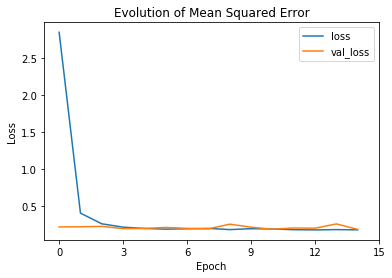

In [36]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [37]:
print(X_val.shape)
print(y_val.shape)

(100, 224, 224, 1)
(100, 2)


In [49]:
y_hat = model.predict([X_val,t_val])
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[:,0]
y_hat_long=y_hat[:,1]

y_hat_lat=scale_up(y_hat_lat,latend,latstart)
y_hat_long=scale_up(y_hat_long,longend,longstart)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,latend,latstart)
y_val_long=scale_up(y_val_long,longend,longstart)

(36, 40)

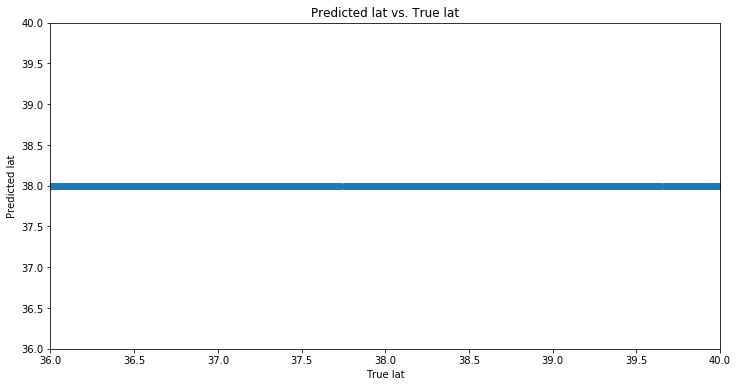

In [51]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(36,40)
ax.set_ylim(36,40)
#draw straight line


(-78, -74)

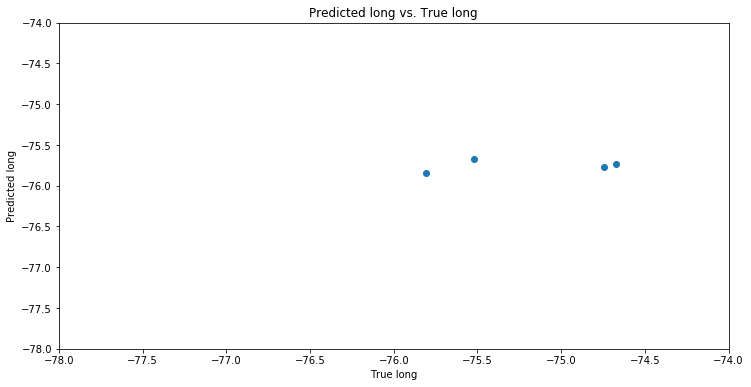

In [36]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-78,-74)
ax.set_ylim(-78,-74)


### Save Model

In [23]:
model_dir='inference_model'
model.save(model_dir)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: inference_model/assets


In [36]:
test_model=tf.keras.models.load_model(model_dir)


In [24]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)

In [ ]:
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=tf.keras.layers.Input(shape=t_train[0].shape)

i=tf.keras.layers.Conv2D(filters=5,kernel_size=10,padding='same',activation='relu')(input_image)
i=tf.keras.layers.Conv2D(filters=1,kernel_size=10,padding='same',activation='relu') (i)
i=tf.keras.layers.Flatten()(i)

t=tf.keras.layers.Flatten()(input_time)
ti=tf.keras.layers.concatenate([i,t])
ti=tf.keras.layers.Dense(256,activation='relu')(ti)
ti=tf.keras.layers.Dropout(0.2)(ti)
outputs=tf.keras.layers.Dense(2,activation='sigmoid')(ti)

model = tf.keras.Model(inputs=[input_image, input_time], outputs=outputs)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
                 loss=haversine_loss)

print(model.summary())

history = model.fit(x=[X_train,t_train], 
                    y=[y_train],
                    validation_data=[[X_val,t_val],y_val],
                    verbose=1, epochs=15, batch_size=64)


### Feed Forward Dense

In [38]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          26493456    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 528)          279312      dense_11[0][0]                   
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 8s 2ms/sample - loss: 2.0387 - regression_lat_loss: 0.8447 - regression_long_loss: 1.1658 - regression_lat_mean_squared_error: 0.8550 - regression_long_mean_squared_error: 1.1837 - val_loss: 0.6580 - val_regression_lat_loss: 0.3201 - val_regression_long_loss: 0.3377 - val_regression_lat_mean_squared_error: 0.3201 - val_regression_long_mean_squared_error: 0.3379
Epoch 2/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6928 - regression_lat_loss: 0.3413 - regression_long_loss: 0.3514 - regression_lat_mean_squared_error: 0.3413 - regression_long_mean_squared_error: 0.3516 - val_loss: 0.6555 - val_regression_lat_loss: 0.3144 - val_regression_long_loss: 0.3413 - val_regression_lat_mean_squared_error: 0.3143 - val_regression_long_mean_squared_error: 0.3412
Epoch 3/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6259 - regression_lat_loss: 0.30

In [40]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

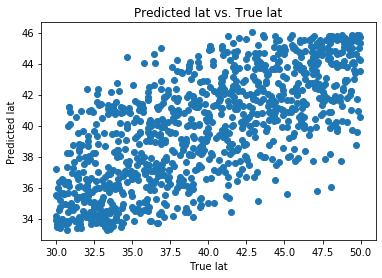

In [41]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

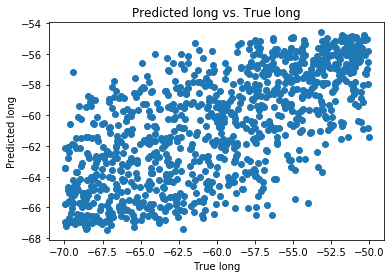

In [42]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)